In [1]:

import sys
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import csv

import pandas as pd
import itertools

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset



In [2]:
# Geometry
length = 1              # Length of the rod

# Material properties
rho = 2760.0                      # Density of AL380 (kg/m^3)

k = 1090.0 *1.5                         # W/m-K
                       # W/m-K
cp = 963.0                        # Specific heat of aluminum (J/kg-K)

alpha = k / (rho * cp)            # Thermal diffusivity

# print('alpha ia',alpha)
#L_fusion = 3.9e3                 # J/kg
L_fusion = 389e3               # J/kg

# Spatial discretization

num_points = 50                  # Number of spatial points
dx = length / (num_points - 1)
print('dx is',dx)
                                   #dt = time_end/num_steps
#num_steps = 200000               # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
# Time Discretization  
# 
time_end = 10               # seconds                         
#num_steps = 10000
# dt = time_end/num_steps
dt = abs(0.5 *(dx**2/alpha))
print('dt is ',dt)
num_steps = round(time_end/dt) +1
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/alpha)
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

dx is 0.02040816326530612
dt is  0.3385286711576597
num_steps is 31
cfl is 0.3385286711576597
stability criteria satisfied


In [3]:
# Initial Conditions
T_L = 866.0                       #  K -Liquidus Temperature (593 c)
T_S = 811.0                       # K- Solidus Temperature (538 C)


# Initial temperature and phase fields
init_temp = 870.0
temperature = np.full(num_points, init_temp)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1.0

temperature[0] = 313.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

#print(temperature_history,phi_history)

In [4]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
    for n in range(1,num_points-1):              # space loop, adjusted range
        #print(f"Step {m}, point {n},Temperature: {temperature}, Phase: {phase}")
        temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
        # if temperature[n] >= T_L:
        #     temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
        #     phase[n] = 0
         
        #     #print(m,n,temperature[n],phase[n])
        # elif T_S < temperature[n] < T_L:
        #     #temperature[n] = temperature[n] - (((k * dt) / (rho*(T_L-T_S)*(cp*(T_L-T_S)-L_fusion)*(dx**2))) * (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
        #     temperature[n] = temperature[n] - ((k/(rho*(cp-(L_fusion/(T_L-T_S)))))* (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
        #     phase[n] = (T_L - temperature[n]) / (T_L - T_S)
        #     #print(m,n,temperature[n],phase[n])
         
        # elif temperature[n]<T_S:
        #     temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
        #     phase[n] = 1
            
        # else:
        #     print("ERROR: should not be here")
         
           # print(m,n,temperature[n],phase[n])
    
    temperature_history.append(temperature.copy())
    phi_history.append(phase.copy())
    #Print for debugging
    print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")


#print(temperature_history)
#print(phi_history)




Step 1, space48,Temperature: [313.         591.5        730.75       800.375      835.1875
 852.59375    861.296875   865.6484375  867.82421875 868.91210938
 869.45605469 869.72802734 869.86401367 869.93200684 869.96600342
 869.98300171 869.99150085 869.99575043 869.99787521 869.99893761
 869.9994688  869.9997344  869.9998672  869.9999336  869.9999668
 869.9999834  869.9999917  869.99999585 869.99999793 869.99999896
 869.99999948 869.99999974 869.99999987 869.99999994 869.99999997
 869.99999998 869.99999999 870.         870.         870.
 870.         870.         870.         870.         870.
 870.         870.         870.         591.5        313.        ], Phase: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
Step 2, space48,Temperature: [313.         521.875      661.125      748.15625    800.375
 830.8359375  848.2421875  858.03320312 863.47265625 866.46435547
 868.09619141

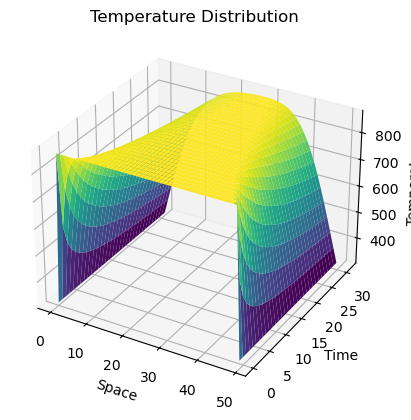

In [5]:
from mpl_toolkits.mplot3d import Axes3D

temperature_history_a = np.array(temperature_history) 
phi_history_a = np.array(phi_history)

time_steps = temperature_history_a.shape[0]
spatial_poitns = temperature_history_a.shape[1]

time = np.arange(time_steps)
space = np.arange(spatial_poitns)

T,X = np.meshgrid(time,space, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,T,temperature_history_a, cmap='viridis')

ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.set_title('Temperature Distribution')

plt.show()


c_lamda = 0.1    #material constant

del_Pcr = 25     # difference between P liquidus and P at critical pressure
u_l = 450000         # dynamic viscosity of liquid
beta = (rho_s - rho_l)/ rho_l 
del_Tf = T_L - T_S
   


g = np.array(np.gradient(temperature_history, axis=1))
t_dot = np.array(np.gradient(temperature_history, axis=0))
t_dot = np.where(t_dot <= 0, 1e-10, t_dot)
Main= g /(t_dot**(5/6))
Pcr = (del_Pcr/u_l*beta*del_Tf)**(1/2)
Niyama = c_lamda *(Pcr)
#print(Main)



In [6]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:

# Define the neural network architecture
class HeatPINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # This is the constructor
        super(HeatPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
             )                                                    

    def forward(self, x, t):                               # This is the forward pass
        input_features = torch.cat([x, t], dim=1)          # Concatenate the input features
        return self.net(input_features)                     # Return the output of the network




# Loss function for data 

def loss_fn_data(u_pred, u_true):
    return nn.MSELoss()(u_pred, u_true)

Preparing the data for Aye Eye

In [8]:

# Training data preparation
x = torch.linspace(0, length, num_points).view(-1, 1).requires_grad_(True) # Spatial dimension of length l
t = torch.linspace(0, time_end, num_steps+1).view(-1, 1).requires_grad_(True) # Temporal dimension of length T
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij') # Create a meshgrid of X and T
X = X.reshape(-1, 1)   # Reshape X to a column vector
T = T.reshape(-1, 1)       # Reshape T to a column vector




inputs = torch.cat([X, T], dim=1)

temp_t = torch.tensor(np.array(temperature_history)) # Convert the temperature history to a tensor
phase_t = torch.tensor(np.array(phi_history))          # Convert the phase history to a tensor
temp_inp = temp_t.reshape(-1,1) # Reshape the temperature tensor to a column vector
phase_inp = phase_t.reshape(-1,1)
print(inputs.shape)
print(T.shape)
print(temp_inp.shape)




torch.Size([1600, 2])
torch.Size([1600, 1])
torch.Size([1600, 1])


Create the custom data set for the training from 

In [9]:
#Data Splitting

train_inputs, val_test_inputs, train_temp_inp, val_test_temp_inp, train_phase_inp, val_test_phase_inp = train_test_split(inputs, temp_inp, phase_inp, test_size=0.2, random_state=42)
val_inputs, test_inputs, val_temp_inp, test_temp_inp, val_phase_inp, test_phase_inp = train_test_split(val_test_inputs, val_test_temp_inp, val_test_phase_inp, test_size=0.5, random_state=42)

class  SpatiotemporalDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, temp_inp, phase_inp):
        self.inputs = inputs
        self.temp_inp = temp_inp
        self.phase_inp = phase_inp

    def __getitem__(self, index):
        return self.inputs[index], self.temp_inp[index], self.phase_inp[index]

    def __len__(self):
        return len(self.inputs)

# Create the dataset and dataloader   

train_dataset = SpatiotemporalDataset(train_inputs, train_temp_inp, train_phase_inp)
val_dataset = SpatiotemporalDataset(val_inputs, val_temp_inp, val_phase_inp)
test_dataset = SpatiotemporalDataset(test_inputs, test_temp_inp, test_phase_inp)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [10]:
def pde_loss(u,u_t,u_xx,alpha):
    residual = u_t - alpha * u_xx
    return nn.MSELoss()(residual,torch.zeros_like(residual))

def boundary_loss(u_left,u_right,boundary_value):
    return torch.mean((u_left - boundary_value)**2 + (u_right - boundary_value)**2)

def initial_condition_loss(u_initial,initial_value):
    return torch.mean((u_initial - initial_value)**2)

In [11]:
# Hyperparameters
hidden_size = 200
learning_rate = 0.01
epochs = 30000
# alpha = 0.01  # Adjust this value based on your problem

# Initialize the model
model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1).to(device)
print(model)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



HeatPINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


In [21]:

# Record losses for plotting
epoch_losses = []



# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    T_pred = model(X, T) 

    # Compute PDE residual
    T_pred = T_pred.reshape(X.shape) # Reshape the prediction to match the shape of X
    T_pred_t = torch.autograd.grad(T_pred, T, torch.ones(T.shape, device=T_pred.device), create_graph=True)[0] # Compute the gradient of T_pred w.r.t. t
    T_pred_x = torch.autograd.grad(T_pred, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0] # Compute the gradient of T_pred w.r.t. x
    T_pred_xx = torch.autograd.grad(T_pred_x, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0] # Compute the second gradient of T_pred w.r.t. x

    # PDE Loss
    pde_residual = T_pred_t - alpha * T_pred_xx # Compute the residual of the PDE
    pde_loss = torch.mean(pde_residual ** 2)  # Compute the mean squared error of the PDE residual
        
    # Boundary condition loss
    # Adjust boundary tensors to have the same size in the time dimension as T
    left_boundary = torch.ones(T.shape, device=X.device, requires_grad=True)*500.0
    right_boundary = torch.ones(T.shape, device=X.device, requires_grad=True)*500.0

    bc_loss = torch.mean((model(left_boundary, T) - 500.0) ** 2) \
            + torch.mean((model(right_boundary, T) - 500.0) ** 2)

    # Initial condition loss
    ic_loss = torch.mean((model(X, torch.zeros_like(T)) - init_temp) ** 2)


    # Data loss

    data_loss = torch.mean((model(X, T) - temp_inp) ** 2)

    # Total loss
    loss = pde_loss + bc_loss + ic_loss + data_loss

    print("pde_loss",pde_loss,"bc_loss",bc_loss,"ic_loss",ic_loss,"data_loss",data_loss)
    epoch_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:

# Record losses for plotting
epoch_losses = []



# Training loop
for epoch in range(epochs):
    model.train()
    epoch_train_losses = 0.0

    for batch_inputs,batch_temp_inp, batch_phase_inp in train_dataloader:
        X_batch, T_batch = batch_inputs[:, 0].view(-1, 1).detach(), batch_inputs[:, 1].view(-1, 1).detach()
        X_batch.requires_grad = True
        T_batch.requires_grad = True

        T_pred_xx = torch.autograd.grad(T_pred_x.sum(), X_batch, create_graph=True, allow_unused=True)[0]



        
        
        

        pde_residual = T_pred_t -alpha*T_pred_xx # Compute the residual of the PDE
        pde_loss_val = pde_loss(T_pred,T_pred_t,T_pred_xx,alpha) # Compute the mean squared error of the PDE residual

        
            # Boundary condition loss

            # Boundary condition loss
        left_boundary = torch.ones_like(T_batch).to(device) 
        right_boundary = torch.ones_like(T_batch).to(device) * length
        u_left = model(left_boundary, T_batch)
        u_right = model(right_boundary, T_batch)
        bc_loss_val = boundary_loss(u_left, u_right, 313.0)
            
        # Initial condition loss
        u_initial = model(X_batch, torch.zeros_like(T_batch).to(device))
        ic_loss_val = initial_condition_loss(u_initial, init_temp)

            

            # Data loss

            #data_loss = torch.mean((model(X, T) - temp_inp) ** 2)
            # Total loss
        loss = pde_loss_val + bc_loss_val + ic_loss_val
        epoch_train_losses += loss.item()

            # Total loss
        loss.backward(retain_graph=True, allow_unused=True)
        
        # Record average epoch loss
        epoch_train_losses /= len(train_dataloader)
        epoch_losses.append(epoch_train_losses)

        #Validation Step
        model.eval()

        with torch.no_grad():
            val_loss =0.0
            for val_inputs, val_temp_inp, val_phase_inp in val_dataloader:
                val_inputs = val_inputs.to(device)
                val_temp_inp = val_temp_inp.to(device)
                val_phase_inp = val_phase_inp.to(device)

                X_val, T_val = val_inputs[:, 0].view(-1, 1), val_inputs[:, 1].view(-1, 1)
                X_val.requires_grad = True
                T_val.requires_grad = True

                
                T_pred = model(X_val, T_val) # Compute the model prediction

                # Compute first derivatives
                T_pred_t = torch.autograd.grad(T_pred.sum(), T_val, create_graph=True, retain_graph=True, allow_unused=True)[0]
                T_pred_x = torch.autograd.grad(T_pred.sum(), X_val, create_graph=True, retain_graph=True, allow_unused=True)[0]

                # Compute second derivatives
                T_pred_xx = torch.autograd.grad(T_pred_x.sum(), X_val, create_graph=True, allow_unused=True)[0]

                # PDE loss

                pde_residual = T_pred_t-alpha*T_pred_xx # Compute the residual of the PDE
                pde_loss = pde_loss(T_pred, T_pred_t, T_pred_xx, alpha) # Compute the mean squared error of the PDE residual

                # Boundary condition loss
                left_boundary = torch.ones_like(T_val).to(device) * 313.0
                right_boundary = torch.ones_like(T_val).to(device) * 313.0
                u_left = model(torch.zeros_like(left_boundary), T_val)
                u_right = model(torch.ones_like(right_boundary) * length, T_val)
                bc_loss_val = boundary_loss(u_left, u_right, 313.0)

                
                
                # Initial condition loss
                u_initial = model(X_val, torch.zeros_like(T_val))   
                ic_loss_val = initial_condition_loss(u_initial, init_temp)


                # Data loss
                #data_loss = torch.mean((model(X, T) - temp_inp) ** 2)

                # Total loss
                loss = pde_loss_val + bc_loss_val + ic_loss_val
                val_loss += loss.item()
            
            val_loss /= len(val_dataloader)
            print(f'Epoch {epoch+1}, Loss: {epoch_train_losses}, Val Loss: {val_loss}')

    
    

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:

# Record losses for plotting
epoch_losses = []



# Training loop
for epoch in range(epochs):
    model.train()
    epoch_train_losses = 0.0

    for batch_inputs,batch_temp_inp, batch_phase_inp in train_dataloader:
        X_batch, T_batch = batch_inputs[:, 0].view(-1, 1).detach(), batch_inputs[:, 1].view(-1, 1).detach()
        X_batch.requires_grad = True
        T_batch.requires_grad = True

        T_pred_xx = torch.autograd.grad(T_pred_x.sum(), X_batch, create_graph=True, allow_unused=True)[0]



        
        
        

        pde_residual = T_pred_t -alpha*T_pred_xx # Compute the residual of the PDE
        pde_loss_val = pde_loss(T_pred,T_pred_t,T_pred_xx,alpha) # Compute the mean squared error of the PDE residual

        
            # Boundary condition loss

            # Boundary condition loss
        left_boundary = torch.ones_like(T_batch).to(device) 
        right_boundary = torch.ones_like(T_batch).to(device) * length
        u_left = model(left_boundary, T_batch)
        u_right = model(right_boundary, T_batch)
        bc_loss_val = boundary_loss(u_left, u_right, 313.0)
            
        # Initial condition loss
        u_initial = model(X_batch, torch.zeros_like(T_batch).to(device))
        ic_loss_val = initial_condition_loss(u_initial, init_temp)

            

            # Data loss

            #data_loss = torch.mean((model(X, T) - temp_inp) ** 2)
            # Total loss
        loss = pde_loss_val + bc_loss_val + ic_loss_val
        epoch_train_losses += loss.item()

            # Total loss
        loss.backward(retain_graph=True, allow_unused=True)
        
        # Record average epoch loss
        epoch_train_losses /= len(train_dataloader)
        epoch_losses.append(epoch_train_losses)

        #Validation Step
        model.eval()

        with torch.no_grad():
            val_loss =0.0
            for val_inputs, val_temp_inp, val_phase_inp in val_dataloader:
                val_inputs = val_inputs.to(device)
                val_temp_inp = val_temp_inp.to(device)
                val_phase_inp = val_phase_inp.to(device)

                X_val, T_val = val_inputs[:, 0].view(-1, 1), val_inputs[:, 1].view(-1, 1)
                X_val.requires_grad = True
                T_val.requires_grad = True

                
                T_pred = model(X_val, T_val) # Compute the model prediction

                # Compute first derivatives
                T_pred_t = torch.autograd.grad(T_pred.sum(), T_val, create_graph=True, retain_graph=True, allow_unused=True)[0]
                T_pred_x = torch.autograd.grad(T_pred.sum(), X_val, create_graph=True, retain_graph=True, allow_unused=True)[0]

                # Compute second derivatives
                T_pred_xx = torch.autograd.grad(T_pred_x.sum(), X_val, create_graph=True, allow_unused=True)[0]

                # PDE loss

                pde_residual = T_pred_t-alpha*T_pred_xx # Compute the residual of the PDE
                pde_loss = pde_loss(T_pred, T_pred_t, T_pred_xx, alpha) # Compute the mean squared error of the PDE residual

                # Boundary condition loss
                left_boundary = torch.ones_like(T_val).to(device) * 313.0
                right_boundary = torch.ones_like(T_val).to(device) * 313.0
                u_left = model(torch.zeros_like(left_boundary), T_val)
                u_right = model(torch.ones_like(right_boundary) * length, T_val)
                bc_loss_val = boundary_loss(u_left, u_right, 313.0)

                
                
                # Initial condition loss
                u_initial = model(X_val, torch.zeros_like(T_val))   
                ic_loss_val = initial_condition_loss(u_initial, init_temp)


                # Data loss
                #data_loss = torch.mean((model(X, T) - temp_inp) ** 2)

                # Total loss
                loss = pde_loss_val + bc_loss_val + ic_loss_val
                val_loss += loss.item()
            
            val_loss /= len(val_dataloader)
            print(f'Epoch {epoch+1}, Loss: {epoch_train_losses}, Val Loss: {val_loss}')

    
    

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the error for a fixed time
t_fixed = torch.tensor([[5]] * 100, requires_grad=True)  # Choose a time to observe error
x_values = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
exact_solution = np.exp(-np.pi**2*0.1)*np.sin(np.pi*x_values.numpy())  # If you have an exact solution function, apply it here

T_pred_fixed_time = model(x_values, t_fixed).detach().numpy().flatten()
error_at_fixed_time = np.abs(T_pred_fixed_time - exact_solution)

plt.figure(figsize=(10, 5))
plt.plot(x_values.detach().numpy(), error_at_fixed_time, label='Error at t = 0.5')
plt.xlabel('Position (x)')
plt.ylabel('Error |T_pred - T_exact|')
plt.title('Prediction Error at Fixed Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
with torch.no_grad():
    # Plot the predicted temperature field
    X_plot, T_plot = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 20, 100)) # Create a meshgrid of X and T
    X_plot = X_plot.reshape(-1, 1)  # Flatten the meshgrid
    T_plot = T_plot.reshape(-1, 1)  # Flatten the meshgrid
    T_pred_plot = model(X_plot, T_plot).reshape(100, 100).numpy() # Predict the temperature at each (x, t) coordinate

    plt.figure(figsize=(10, 5))
    plt.contourf(X_plot[:, 0].numpy().reshape(100, 100), T_plot[:, 0].numpy().reshape(100, 100), T_pred_plot, cmap='coolwarm')
    plt.xlabel('Position (x)')
    plt.ylabel('Time (t)')
    plt.title('Predicted Temperature Field')
    plt.colorbar()
    plt.grid(True)
    plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

time_steps = temperature_history_a.shape[0]
spatial_poitns = temperature_history_a.shape[1]

x1 = torch.linspace(0, 1, spatial_poitns).view(-1, 1).requires_grad_(True) # Spatial dimension of length l
t1 = torch.linspace(0, 10, time_steps).view(-1, 1).requires_grad_(True) # Temporal dimension of length T
X1, T1 = torch.meshgrid(x1.squeeze(), t1.squeeze(), indexing='ij') # Create a meshgrid of X and T


# Flatten X and T to pass as separate inputs to the model
x_flat = X1.reshape(-1, 1)
t_flat = T1.reshape(-1, 1)

# Predict the temperature field
with torch.no_grad():
    predicted_temperature = model(x_flat, t_flat).detach().numpy()

# Reshape the predicted temperature to plot the surface
predicted_temperature = predicted_temperature.reshape(time_steps, spatial_poitns).T
print(predicted_temperature)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1.detach().numpy(), T1.detach().numpy(), predicted_temperature, cmap='viridis')
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.set_title('Predicted Temperature Distribution')
plt.show()
